# 1. Doodle Scheduling

In [5]:
using JuMP, NamedArrays, Clp

availability =
  [ 0 0 1 1 0 0 0 1 1 0 0 0 0
    0 1 1 0 0 0 0 0 1 1 0 0 0
    0 0 0 1 1 0 1 1 0 1 1 1 1
    0 0 0 1 1 1 1 1 1 1 1 1 0
    0 0 0 0 0 0 1 1 1 0 0 0 0
    0 1 1 0 0 0 0 0 1 1 0 0 0
    0 0 0 1 1 1 1 0 0 0 0 0 0
    1 1 0 0 0 0 0 0 0 0 1 1 1
    1 1 1 0 0 0 0 0 0 1 1 0 0
    0 0 0 0 0 0 0 1 1 0 0 0 0
    0 0 0 0 0 0 1 1 1 0 0 0 0
    1 1 0 0 0 1 1 1 1 0 0 1 1
    1 1 1 0 1 1 0 0 0 0 0 1 1
    0 1 1 1 0 0 0 0 0 0 0 0 0
    1 1 0 0 1 1 0 0 0 0 0 0 0 ]

TIMES = ["10:00","10:20","10:40","11:00","11:20","11:40","lunch","1:00","1:20","1:40","2:00","2:20","2:40"]
NAMES = [:Manuel,:Luca,:Jule,:Michael,:Malte,:Chris,:Spyros,:Mirjam,:Matt,:Florian,:Josep,:Joel,:Tom,:Daniel,:Anne ]
times = NamedArray( availability, (NAMES,TIMES), ("NAME","TIME"))

nolunch = [1:6;8:13]
m = Model(solver = ClpSolver())
@variable(m, x[NAMES, TIMES] >= 0)
@constraint(m, a[j in TIMES[nolunch]], sum(x[i,j] * times[i,j] for i in NAMES) == 1 )
@constraint(m, sum(x[i,"lunch"] * times[i, "lunch"] for i in NAMES) == 3)
@constraint(m, b[i in NAMES], sum(x[i,j] * times[i,j] for j in TIMES) == 1)
println(solve(m))

for j in TIMES
    for i in NAMES
        if (getvalue(x[i,j]) > 0.0)
            println(j, ": ",i)
        end
    end
end
    

Optimal
10:00: Matt
10:20: Daniel
10:40: Tom
11:00: Manuel
11:20: Anne
11:40: Joel
lunch: Malte
lunch: Spyros
lunch: Josep
1:00: Florian
1:20: Chris
1:40: Luca
2:00: Jule
2:20: Michael
2:40: Mirjam


# 2. Car Rental

In [119]:
using JuMP, Clp, Distances
agencies = [:a1, :a2, :a3, :a4, :a5, :a6, :a7, :a8, :a9, :a10]
demand = Dict( zip( agencies, [10, 6, 8, 11, 9, 7, 15, 7, 9, 12]))
supply = Dict( zip( agencies, [8, 13, 4, 8, 12, 2, 14, 11, 15, 7]))
coords = Dict( zip( agencies, [[0 0], [20 20], [18 10], [30 12], [35 0], [33 25], [5 27], [5 10], [11 0], [2 15]]))

m = Model(solver=ClpSolver())

@variable(m, x[agencies,agencies] >= 0)          # x[i,j] is cars shipped from agency i to agency j.

@constraint(m, sup[i in agencies], sum(x[i,j] for j in agencies) == supply[i] )   # supply constraint
@constraint(m, dem[j in agencies], sum(x[i,j] for i in agencies) == demand[j] )   # demand constraint

LoadError: [91mUndefVarError: dist not defined[39m

# 3. Building a Stadium

In [37]:
using JuMP

tasks = 1:18
durations = [2 16 9 8 10 6 2 2 9 5 3 2 1 7 4 3 9 1]
predecessors = ( [], [1], [2], [2], [3], [4,5], [4], [6], [4,6], [4], [6], [9], [7], [2], [4,14], [8,11,14], [12], [17] )
pred_dict = Dict(zip(tasks,predecessors));   # dictionary mapping tasks --> predecessors.

# additional columns of data (maximum reduction possible )
max_reduction =  [0,  3,  1,  2,  2,  1, 1, 0,  2,  1,  1, 0, 0,  2,  2, 1,  3, 0]  # max reduction (in weeks)
cost_reduction = [0, 30, 26, 12, 17, 15, 8, 0, 42, 21, 18, 0, 0, 22, 12, 6, 16, 0]  # cost of reduction ($1,000/week)
m_dict = Dict(zip(tasks,max_reduction));
c_dict = Dict(zip(tasks,cost_reduction));
bonus_amount = 30     # bonus for expediting the project ($1,000/week )
;

#### Part A

In [7]:
using JuMP,Clp
m = Model(solver=ClpSolver())

@variable(m, tstart[tasks])

# one-line implementation of the constraints:
@constraint(m, link[i in tasks, j in predecessors[i]], tstart[i] >= tstart[j] + durations[j])

@constraint(m, tstart[1] == 0)
@objective(m, Min, tstart[18] + durations[18])     # total duration is start time of last task + duration of last task.

solve(m)
println("minimum amount of time required to complete the project: ", getobjectivevalue(m), " weeks")

minimum amount of time required to complete the project: 64.0 weeks


#### Part B

In [43]:
using JuMP,Clp
n = Model(solver=ClpSolver())

@variable(n, reducs[tasks]) #number of weeks reduced
@variable(n, tstart[tasks])

@constraint(n, link[i in tasks, j in predecessors[i]], tstart[i] >= tstart[j] + (durations[j] - reducs[j]))
@constraint(n, z[i in tasks], max_reduction[i] >= reducs[i])
@constraint(n, tstart[1] == 0)

@objective(n, Max, sum(reducs[i] * (bonus_amount - cost_reduction[i]) for i in tasks))
solve(m)



:Optimal

# 4. Museum Site Planning

In [8]:
A = [3 -1; 2 3; 0 1; 0 -1; -1 0];
b = [1500; 2100; 500; 0; 0]

using JuMP, Clp

m = Model(solver=ClpSolver())
@variable(m, r >= 0)           # radius
@variable(m, x[1:2])           # coordinates of center
for i = 1:size(A,1)
    @constraint(m, A[i,:]'*x + r*norm(A[i,:]) <= b[i])
end
@objective(m, Max, r)     # maximize radius

status = solve(m)
center = getvalue(x)
radius = getvalue(r - 50)

println(status)
println("The coordinates of the museum center should be located at: ", center, " (in feet)")
println("The largest possible radius is: ", radius, " feet")

Optimal
The coordinates of the museum center should be located at: [244.029, 244.029] (in feet)
The largest possible radius is: 194.0285267938019 feet


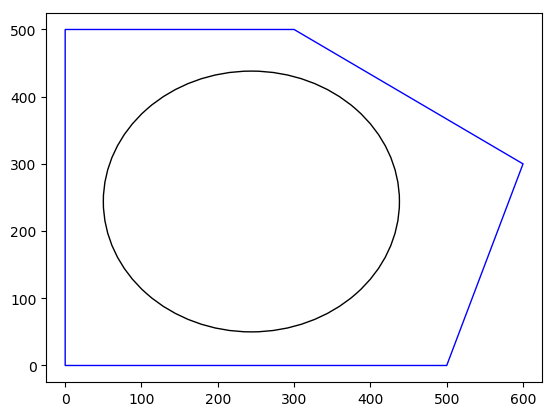

In [9]:
using PyPlot
import PyPlot.plt

using PyCall
@pyimport matplotlib.patches as patches
fig, ax = subplots()
xlim(-25, 625)
ylim(-25, 525)
poly = patches.Polygon([0 0; 0 500; 300 500; 600 300; 500 0], closed=true, fill=false, ec="b")
ax[:add_artist](poly)

circle = patches.Circle(center, radius, fill=false)
ax[:add_artist](circle)

show()
